# Particle analysis tutorial

This is a tutorial to show how basic particle analysis by thresholding works. We will select particles by contrast difference with the background, filter by size and measure properties including minimum/maximum/mean diameter, area, circularity and more. 

In [1]:
#Import dependancies - here we are looking at particles in a single image, so we use Micrograph() to hold the image

from SimpliPyTEM.Micrograph_class import * 
#This praticle analysis module contains the functions suitable for performing this type of particle analysis 
from SimpliPyTEM.Particle_analysis import * 


<Figure size 640x480 with 0 Axes>

## Locate files

Here I get a list of files from the directory Particle_analysis_files, these are the fiels I will use for this tutorial. As they are in a different folder from my working directory I need to include a prefix to them, Here I will use pythons generator expression syntax to do this effectively.

In [2]:
files = ['Particle_analysis_files/'+x for x in os.listdir('Particle_analysis_files')]
print(files)

['Particle_analysis_files/CC_15_2021_H_0018.dm3', 'Particle_analysis_files/CC_15_2021_H_0022.dm3', 'Particle_analysis_files/CC_15_2021_H_0016.dm3']


In [3]:
print(os.listdir('.'))

['Example_image_0021_250nmscale.jpg', 'Output_video.avi', '.DS_Store', 'Fibrils_Example_100nmscale.jpg', 'Cy5.5_A5_0006_0.5umscale.jpg', 'images', 'First_frame.jpg', 'Cy5.5_A5_0006.jpg', 'Cy5.5_A5_0006_0.5µmscale.jpg', 'Example-0003_250nmscale.jpg', 'Cy5.5_A5_0006.dm3', 'Frames', 'Fibres_1.jpg', 'Example_image_0021.dm3', 'Fibrils_Example.dm3', 'Output_video.mp4', 'A1_Tribloc-100000X-0003.dm4', 'Fibrils_Example.jpg', 'Example_image_0021.jpg', 'Particle_data.csv', 'gold_growth_video_holder_test_070921.tif', 'MicrographAnalysisTutorial.ipynb', '.ipynb_checkpoints', 'Particle_analysis_files', 'Last_frame.jpg', 'imagesTutorial_image.tif_25nmscale.tif', 'MicroVideoAnalysisTutorial.ipynb', 'gold_growth_video_holder_test_070921_25nmscale.jpg', 'Fibres_1_25nmscale.jpg', 'Particle_analysis_tutorial.ipynb', 'Video_averaged.jpg', '__temp__.mp4', 'gold_growth_video_holder_test_070921.dm4']


## Open Micrograph

For now we are only going to focus on one of the 3 files, we will come back to the others later though. 

In [4]:
im = Micrograph()
im.open_dm(files[0])

Particle_analysis_files/CC_15_2021_H_0018.dm3 opened as a Micrograph object


In [5]:
#Lets see how it looks 
im.imshow()

So we can see particles, but the contrast is pretty poor, while we dont have to, its best to improve this before continuing with the analysis. Lets move do this with a preprocessing step.

## Preprocess image

First thing to do is check how this histogram looks:

In [6]:
im.plot_histogram(sidebyside=True)

Now although it is not strictly neccessary, I prefer working with 8-bit images, this is standard for  images and has the pixel values scaled between 0-255. It also improves the contrast enhancement. 

In [7]:
im8bit = im.convert_to_8bit()
im8bit.plot_histogram(sidebyside=True)

Next I want to normalise contrast across the image. This is particularly important if there is uneven contrast in the image. We are going to detect particles by thresholding, which makes it important that the contrast in the image is uniform. If for example, the corners of the image are darker than the center, possibly due to a missaligned beam or aperture, it can become difficult to separate the particles effectively. Here I use local normalisation (see micrograph tutorial) to perform this. You may notice there is a patchwork effect produced by this, while this can be avoided by running with padding (`pad=True`), in my experience, this effect does not cause an issue.

In [ ]:
im8bitLN= im8bit.Local_normalisation(6)
im8bitLN.plot_histogram(sidebyside=True)

Next I gaussian filter - this smooths the edges of the particles to make them easier to threshold.

In [9]:
im8bit_gaussian= im8bitLN.gaussian_filter(3)
im8bit_gaussian.plot_histogram(True)

Finally, I am going to improved the contrast using the clip_contrast method:

In [10]:
im8bit_clipped = im8bit_gaussian.clip_contrast(saturation=0.1)
im8bit_clipped.plot_histogram(True)
im_processed = im8bit_clipped

Maxmium value :  177
Minimum value :  85


The local normalisation patchwork effect has finally been seen, this shouldnt cause an issue though. 

If you have a large image, particle picking can become slow. You may want to bin image (reduce the size) to speed up particle picking:

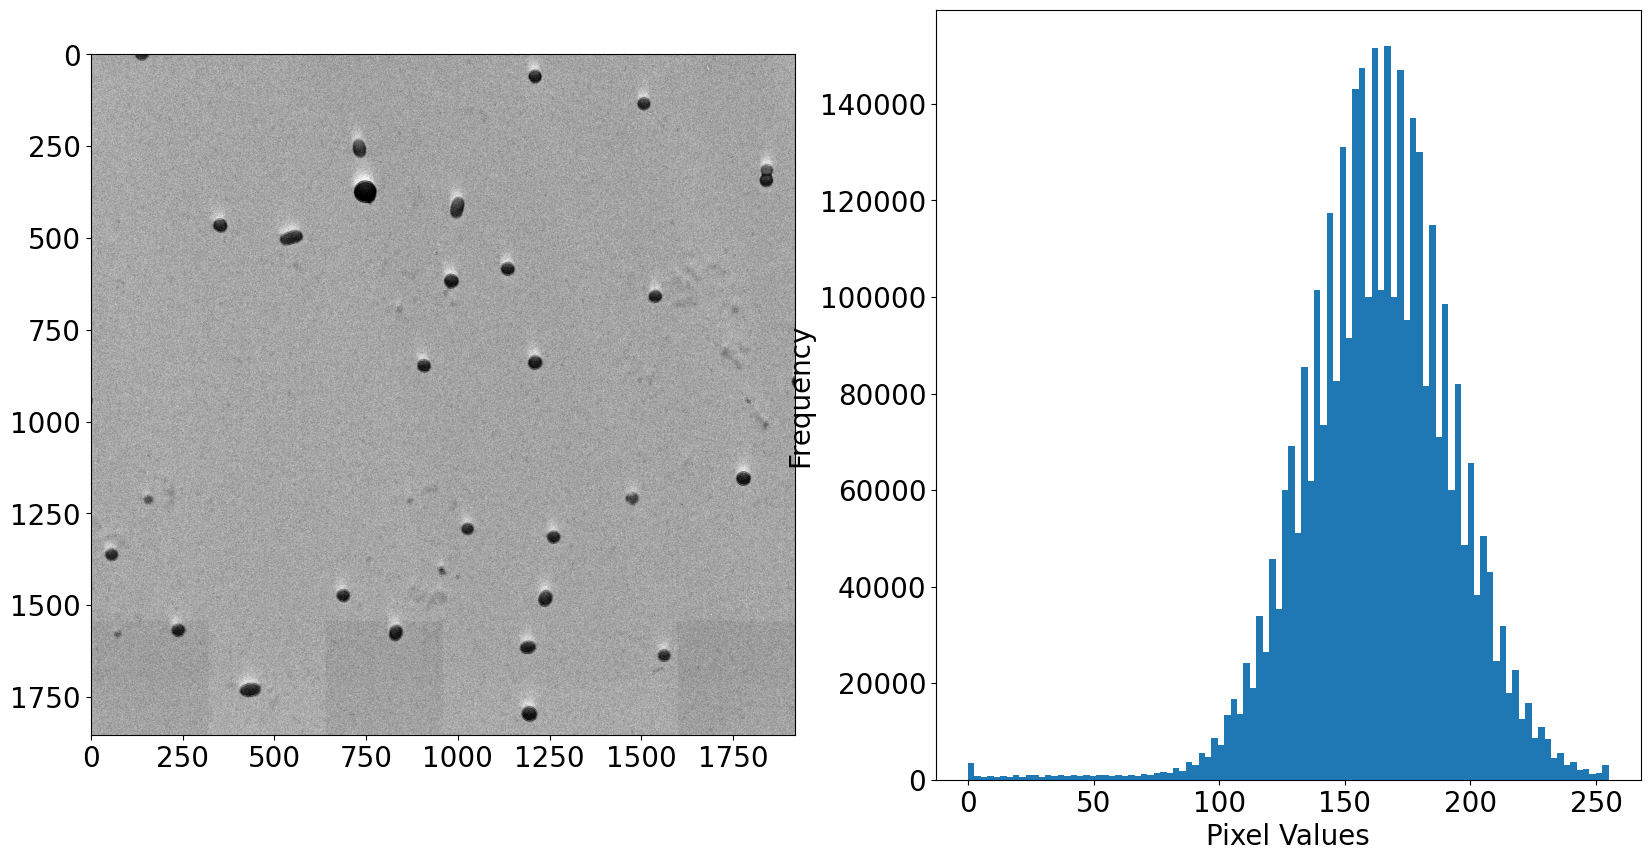

In [11]:
im_processed = im8bit_clipped.bin(2)
im_processed.plot_histogram(True)

## Thresholding

The first step when analysing particles is to separate the particles from the background. The most common method for this is by simply thresholding, this chooses a value. Anything under this value is set to black (0), whilst anything above the value is set to white. 

SimpliPyTEM's thresholding implementation automataically erodes and dilates the threshold to improve the resultss. Using this function is optional however, you can explore using tricks using other image analysis methods to best threshold your image. The key point here is that the output is a binary image with the particles as white and the background as black.

This implementation also assumes your image is brightfield, i.e. the particles are dark and the background is light. This assumption can be reversed by setting `brightfield=False` as a parameter,


Finding a good threshold value is guided by the histogram and by trial and error:

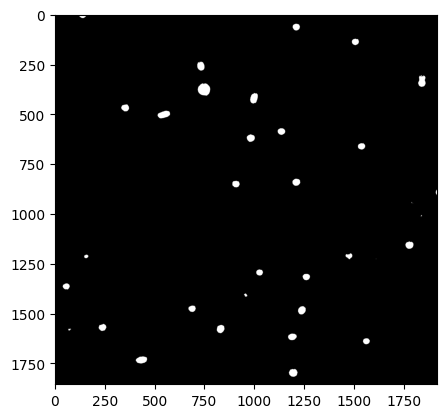

In [12]:
thresh = Threshold(im_processed.image, 100)
plt.imshow(thresh)
plt.show()


How do thresholds compare? Here I will crop a small region of the image showing a particle and compare how different threshold values make the particle appear.

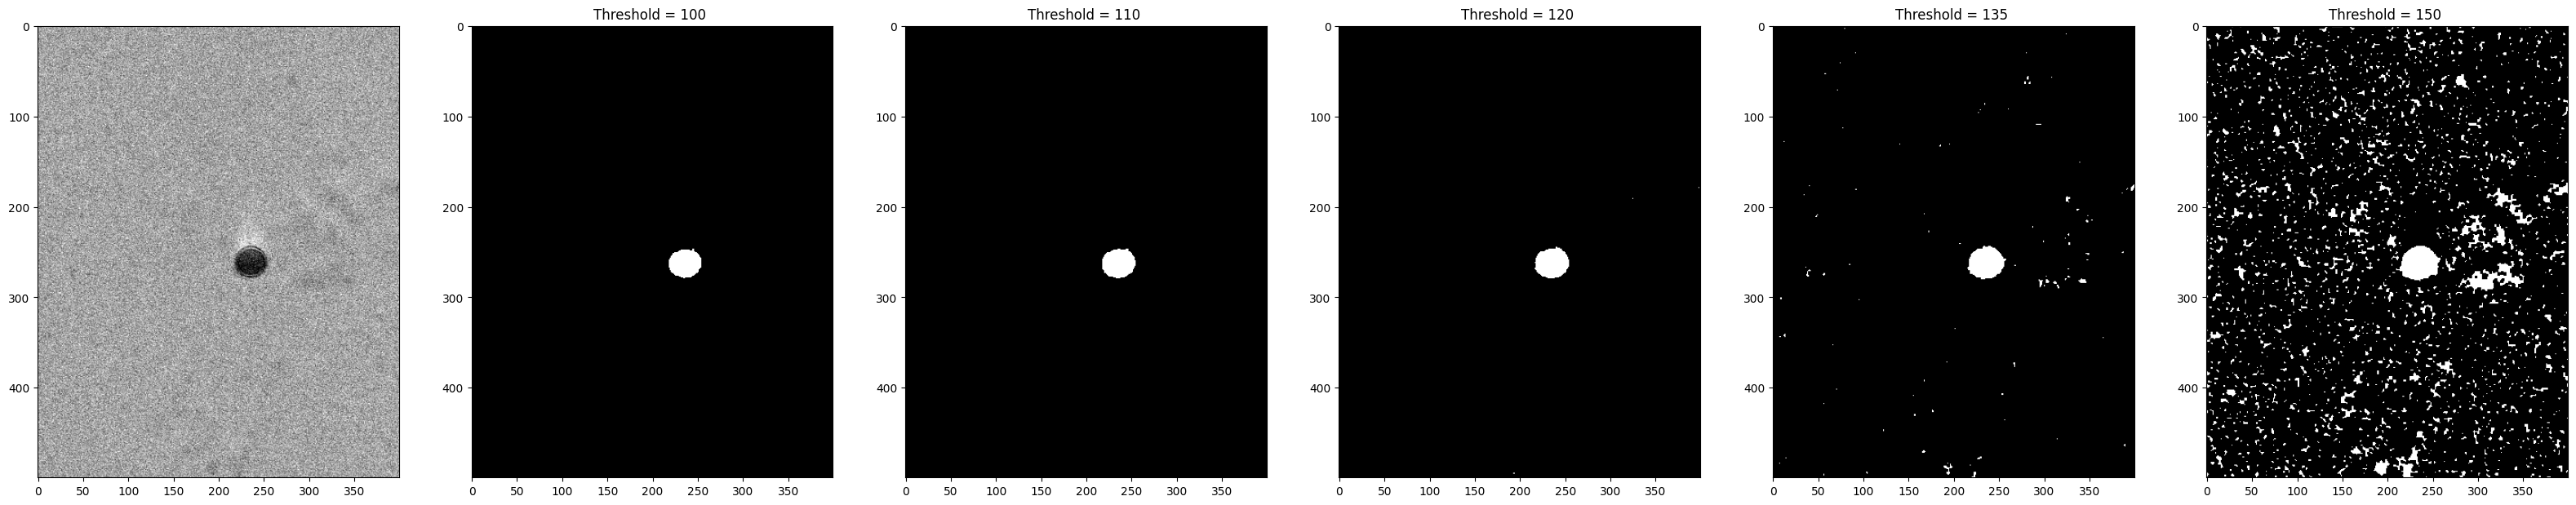

In [13]:
thresholds = [100, 110,120,135,150]
fig, ax = plt.subplots(1,6, figsize =(40,10))
ax[0].imshow(im_processed.image[400:900, 1300:1700])
for i in range(len(thresholds)):
    ax[i+1].imshow(Threshold(im_processed.image, thresholds[i])[400:900, 1300:1700])
    ax[i+1].set_title('Threshold = {} '.format(thresholds[i]))
    
plt.show()




Here we see that increasing the threshold value leads to more noise being selected which may cause issues with falsely selecting particles. This image has very high contrast particles which makes this step easier. Here I will choose a threshold of 120, as some surrounding noise is ok, because we will filter by size, its best to pick up the full particle though. Lets solidify this then:

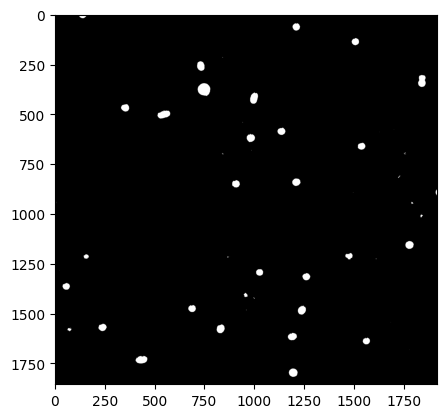

In [14]:
threshold = 120
thresh= Threshold(im_processed.image, threshold)
plt.imshow(thresh)
plt.show()

## Locating particles

Using a function called 'Find_contours' which locates the edges of the particles. This also filters the particles by size - a minimum area (in number of pixels) is given. It will also remove particles on the edge of the image. A max size can also be added (using the `maxsize` parameter) if required, here we are only interested in the minimum size but there may be images with aggregates and similar large items which you may not want to select. 
This returns two objects: 

    - contours_im is a list of arrays containing the coordinates which define the particles selected. 
    - mask is a binary image showing particles in white.

In [15]:
contours_im, mask =Find_contours(thresh, minsize=500)

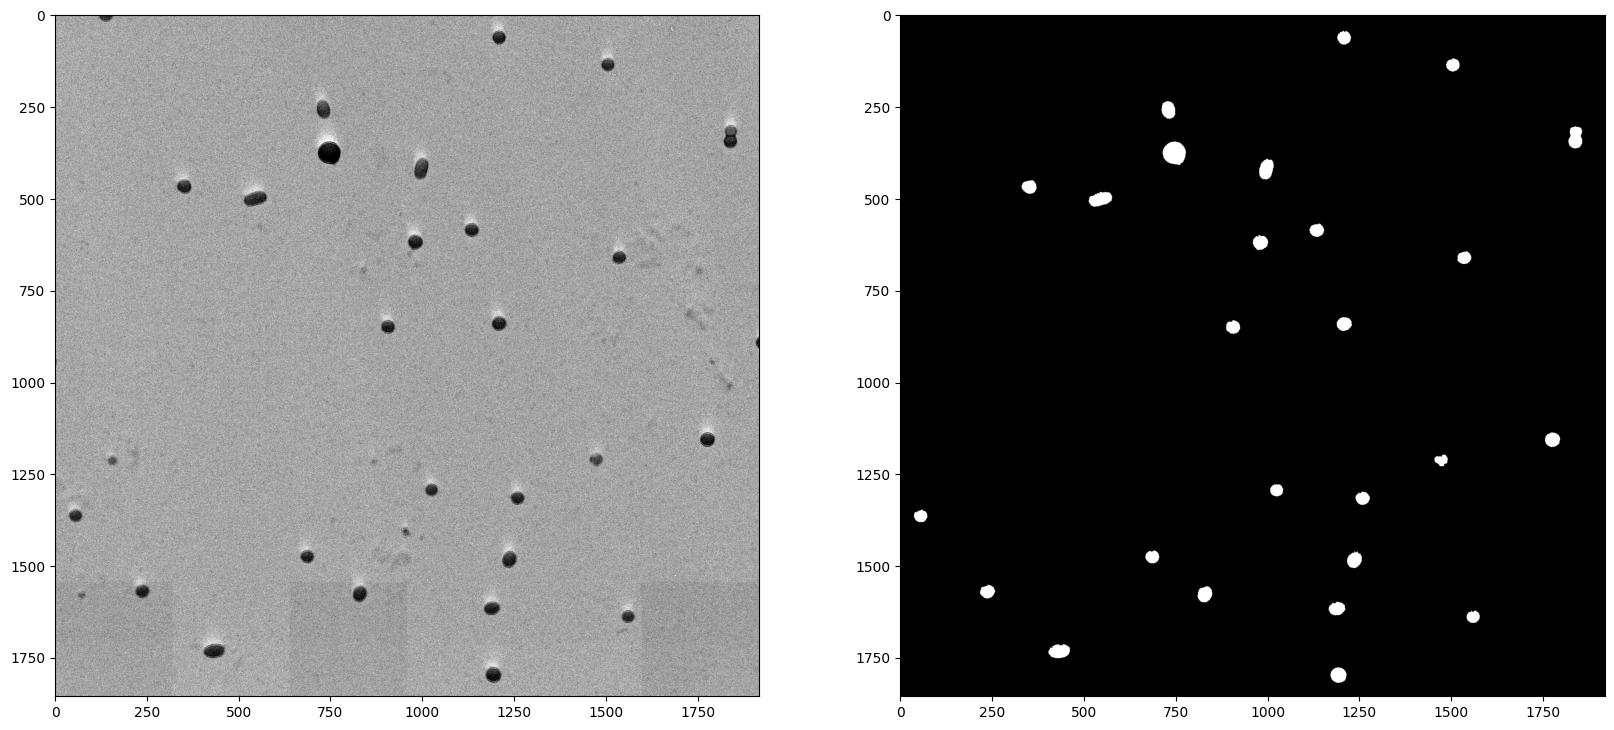

In [16]:
#Lets compare the mask to the original using the micrograph.show_pair() function

im_processed.show_pair(mask)

Now theres a few very small particles that I'm not convinced are real (e.g. see bottom left, around 50,3200), now this could be a different populataion that I am interested in, but here I'm not interested in these We can filter this out by raising the minimum size parameter:

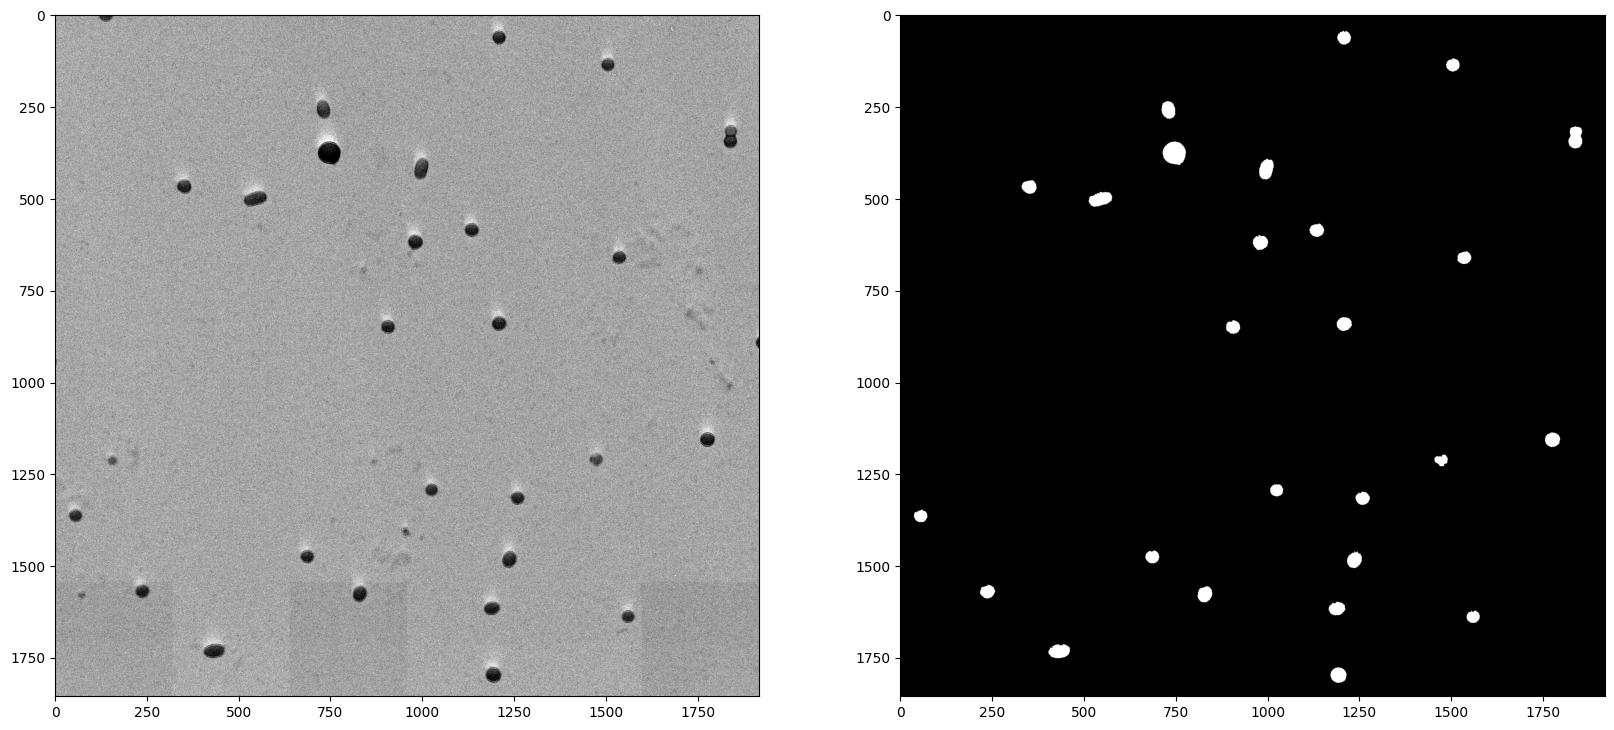

In [17]:
contours_im, mask =Find_contours(thresh, minsize=750)
im_processed.show_pair(mask)

This looks like it gets everything that I think is a particle, without selecting anything else which is the ideal scenario. Lets move on with this. 

## Collecting and plotting paraticle data

Uses Collect_particle_data() function with two inputs: the contours_im defined in the last section and the pixel size of the image, which can be located from the micrograph object im_processed (remember that the image has been binned so its important to use im_processed rather than im) 

The data collected will be in the same unit as the pixelSize input that you give.Having the pixelSize attribute saved in the micrograph object is quite useful here. You may want to double check that the pixelUnit is what you expect though. Here I want to work in nanometers, lets first see if thats what I have. 




In [18]:
print(im_processed.pixelSize, im_processed.pixelUnit)

# Good thing I checked! I want it in nanometers, so lets change that: 

im_processed.pixelSize = im_processed.pixelSize * 1000
im_processed.pixelUnit = 'nm'
print(im_processed.pixelSize, im_processed.pixelUnit)

0.0027170402463525534 µm
2.7170402463525534 nm


Now we can use this to collect correctly scaled data:

In [19]:
data = Collect_particle_data(contours_im, im_processed.pixelSize)

The data is in a dictionary with keys being the features described. To see the features available use data.keys()


In [20]:
print(data.keys())

dict_keys(['Area', 'Centroid_x', 'Centroid_y', 'Perimeter', 'Circularity', 'Width', 'Height', 'Radius', 'Major-Minor Ratio'])


Some of these features are pretty self explanatory but lets go through them here: 
    
       Area - The area of the particle in the image
            Centroid - The center point coordinate of the particle (x, y)

       Circularity - The area of the particle divided by the area of a circle that completely bounds the particle, giving a value for how circular it is (or how much of a circle it fills)

       Width - The width of the smallest possible rectangle that could fully contain the particle

       Height - The height of the smallest possible rectangle that could fully contain the particle

       radius - The radius of the smallest possible circle that could fully contain the particle. 

       Major-Minor Ratio  - The ratio between height and width

To use the individual data, use these keys: 

In [21]:
print(data['Width'])

[88.08752810373034, 94.44764146695839, 96.21093367242838, 100.53048911504447, 97.77364847445824, 92.37936837598681, 99.04267989872473, 164.6523342071964, 105.96456960774958, 97.81344886869192, 107.00713264295203, 98.18787315038247, 86.94528788328171, 95.99268447936105, 96.78730349611087, 113.34439187355372, 100.53048911504447, 97.98311877848498, 103.74681701530974, 94.77759088103, 82.61153282084788, 91.90359819460437, 88.96217286107344, 86.94528788328171, 105.96456960774958, 100.53048911504447]


We can plot some of this data using matplotlib: 

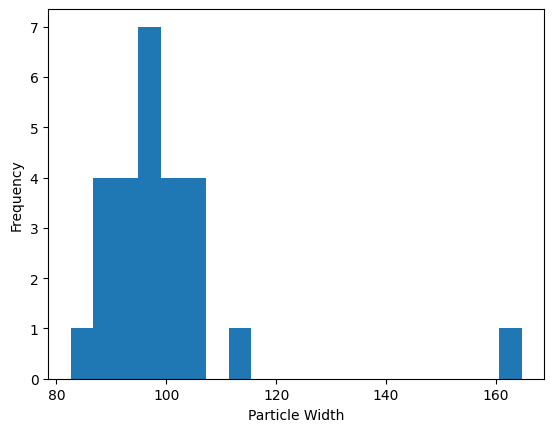

In [22]:
plt.hist(data['Width'], bins=20)
plt.xlabel('Particle Width')
plt.ylabel('Frequency')
plt.show()

Now before we move on from here, There is an additional parameter for Collect_particle_data called `multimeasure`. This uses an additional function to measure the particles diameter at many different positions around the particle, the maximum, minimum, mean and standard deviation of the diameter are then kept, along with the number of measurements per particle: 

In [23]:
data = Collect_particle_data(contours_im, im_processed.pixelSize, multimeasure=True)
print(data.keys())

dict_keys(['Area', 'Centroid_x', 'Centroid_y', 'Perimeter', 'Circularity', 'Width', 'Height', 'Radius', 'Major-Minor Ratio', 'Min diameter', 'Max diameter', 'Mean diameter', 'Stddev diameter', 'Measurements'])


In [24]:
print(data['Measurements'])

[8, 26, 14, 32, 38, 12, 26, 44, 18, 18, 18, 26, 20, 18, 30, 16, 10, 24, 12, 26, 18, 14, 16, 10, 20, 38]


Here we have plenty of measurements, however sometimes there are very few measurements, particularly with small particles. 

To improve this, we can go back a step and redo the Find_contours() step with `complex_coords=True`. The resulting contours will be better defined as it will no longer try to remove the redundant coordinates of the edges, see [OpenCV's contours documentation for more details](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html).

The multimeasure should then have more coordinates to work with and thus have more measurements, the downside here is that evrything will take longer to run however.

In [25]:
contours_im, mask =Find_contours(thresh, minsize=750, complex_coords=True)
data = Collect_particle_data(contours_im, im_processed.pixelSize, multimeasure=True)
print(data['Measurements'])

[54, 70, 72, 130, 146, 54, 106, 184, 78, 54, 68, 106, 68, 56, 94, 56, 72, 56, 68, 68, 70, 50, 60, 50, 64, 134]


See? loads more measurements...

## Plotting data

Now we just need to plot the data! Here is an example plot I have made with the seaborn and matplotlib libraries. I'm not going to go into the details of this too much, if you dont know much about plotting data in python I recommend you look at the matplotlib and/or seaborn libraries for inspiration. Or you can skip this step and export the data to a .csv file below. 

[56.01276995305164, 237.8532008830022, 351.5833333333333, 433.39570737605806, 545.188966156699, 686.5207151452638, 730.3547197640117, 746.7115193644488, 829.5474244193589, 906.2961706253029, 980.5648339534241, 996.8480164863471, 1024.835903293356, 1134.2615931491355, 1188.9844573966138, 1193.2166908914728, 1208.7122407245106, 1208.494843646041, 1236.6824411688647, 1258.9873143047905, 1473.2845310051487, 1504.7108987968859, 1535.6617852161783, 1559.8902953586496, 1775.7853900123814, 1838.4618473895582] [1365.303661971831, 1570.878114159571, 469.9110503946569, 1732.9551592099958, 503.24756606397773, 1476.3010142685232, 260.5076204523107, 377.9629813527529, 1578.0094719086544, 851.2478591048634, 621.2499655505029, 421.79773312725393, 1294.931467732724, 587.8836645661657, 1617.0169303358311, 1797.7123304263564, 842.605901256208, 64.23819028609448, 1484.7070080165502, 1316.8519445835418, 1213.3089321692412, 138.38499646142958, 662.6124476987447, 1639.369006520905, 1157.4799834915393, 335.60

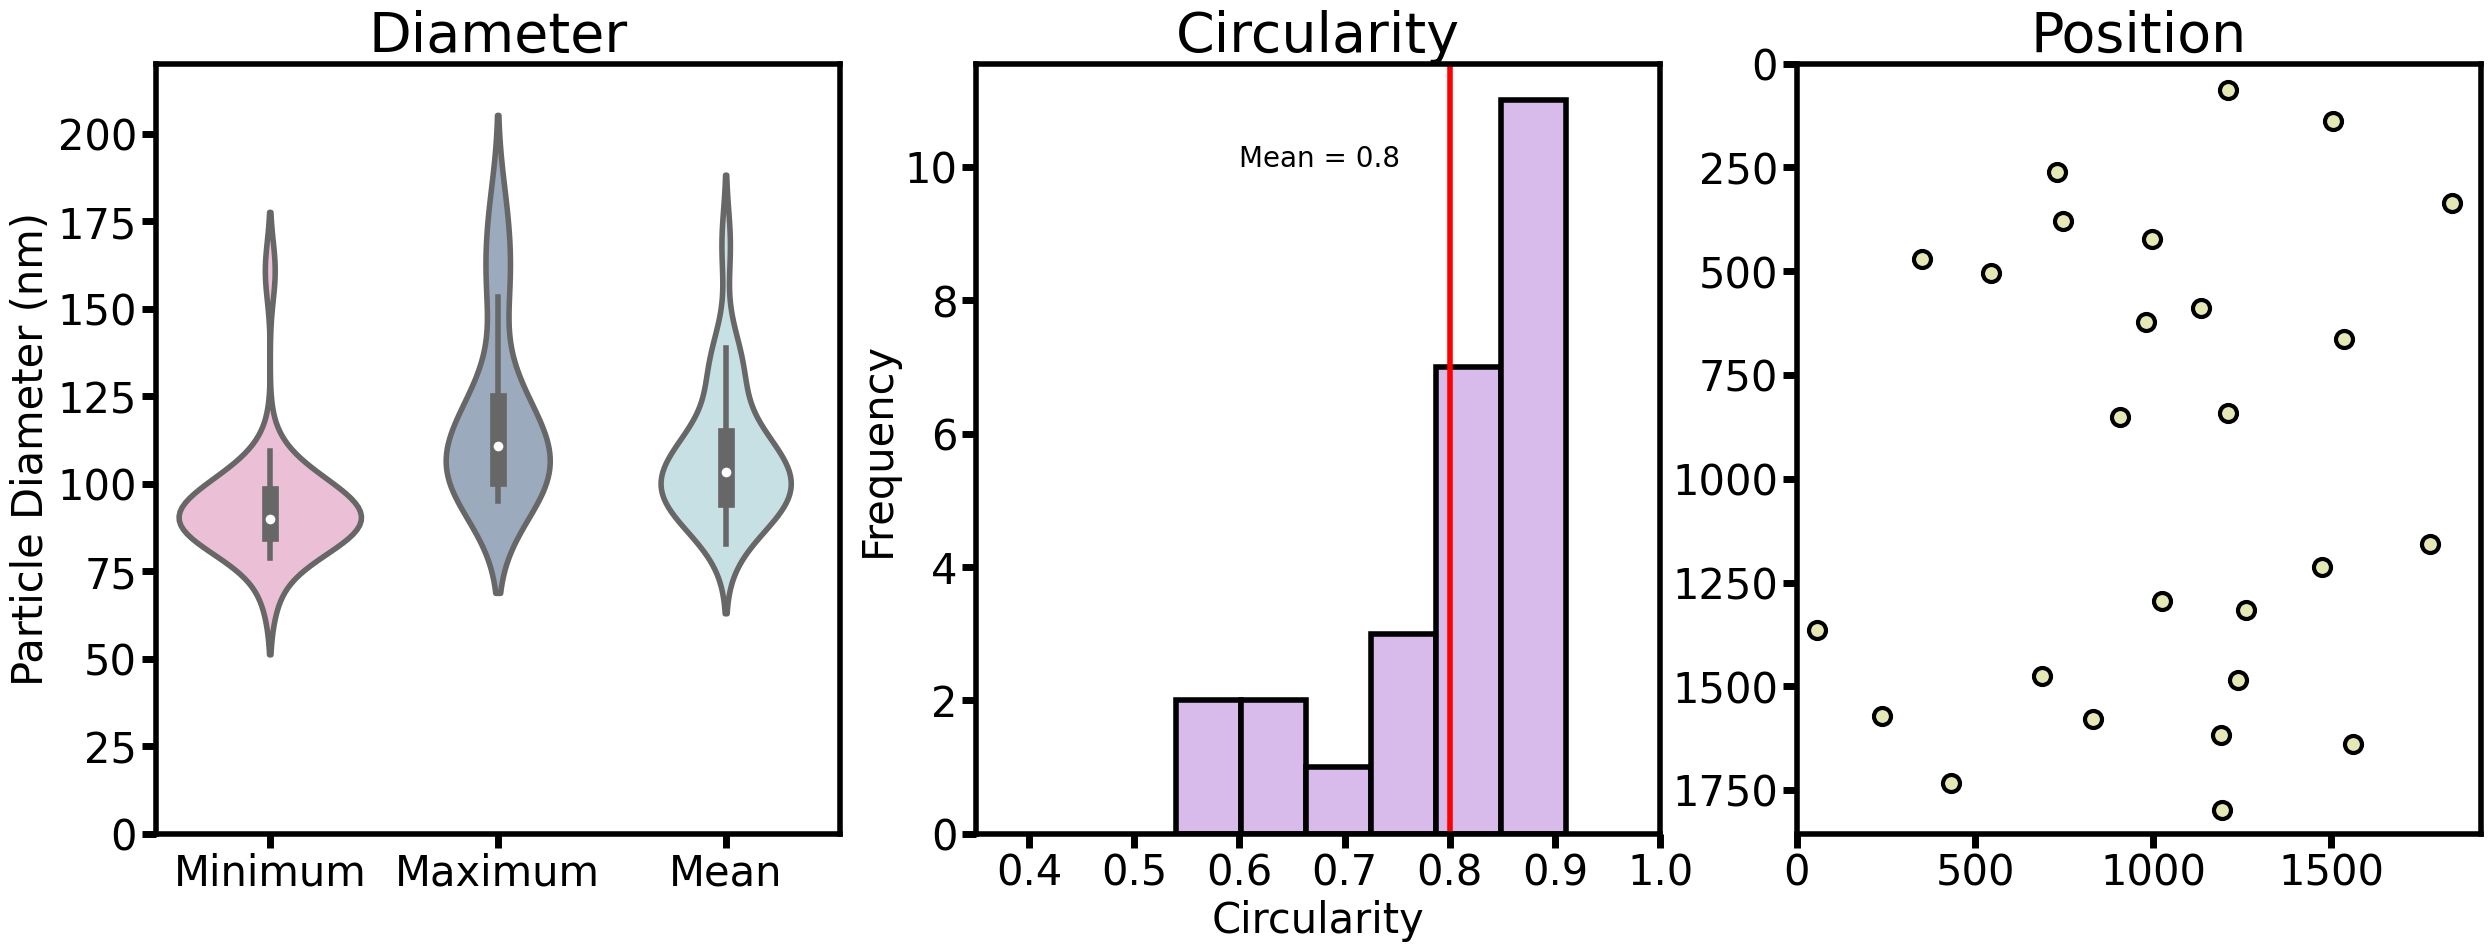

In [26]:
import seaborn
import matplotlib 
import matplotlib.pyplot as plt

#Get data 
hdata= data['Max diameter']
wdata = data['Min diameter']
mdata = data['Mean diameter']
cdata= data['Circularity']
xpos = data['Centroid_x']
ypos = data['Centroid_y']

print(xpos, ypos)

#Change global parameters 
matplotlib.rcParams['font.size']=30
matplotlib.rcParams['axes.linewidth'] = 4
matplotlib.rcParams['lines.linewidth'] = 4

#Create a figure with 3 subplots
fig, ax = plt.subplots(1,3,figsize=(30,10))



#Make Ticks bigger
for a in ax:
    a.xaxis.set_tick_params(width=5, length=10)
    a.yaxis.set_tick_params(width=5, length=10)

#Set the seaborn color palette to be my color palette
colors = ['#F2B8D5', '#95A9C1','#C2E4E9','#D8BBEA','#E5E8B5']
seaborn.set_palette(seaborn.color_palette(colors))

#Plot the diameter violin plot
seaborn.violinplot([wdata, hdata,mdata] ,ax=ax[0], linewidth=4, edgecolor='black')

#Set violin plot labels and limits
ax[0].set_ylim(0,220)
ax[0].set_title('Diameter', fontsize=40)
ax[0].set_ylabel('Particle Diameter (nm)')
ax[0].set_xticklabels(['Minimum', 'Maximum', 'Mean'])

#Plot histogram of Circularity
ax[1].hist(cdata, color='#D8BBEA',edgecolor='black',linewidth=4, bins=6)
ax[1].set_title('Circularity', fontsize=40)
ax[1].set_xlabel('Circularity')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks([x/10 for x in range(4,11)])
ax[1].set_xlim(0.35,1)

#Add a line to show the mean 
ax[1].axvline(np.mean(cdata), color='red')
label='Mean = ' +str(round(np.mean(cdata),2))
ax[1].annotate(label, (0.6,10), fontsize=20)

#Plot the positions of the particles on a scatter plot
ax[2].scatter( xpos, ypos , color='#E5E8B5', marker='o',edgecolors='black',s=150, linewidth=3)
ax[2].set_title('Position', fontsize=40)
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_xlim(0, 1919)
ax[2].set_ylim(1855,0)

#Show plot (can also use plt.savefig('Name.png') to save the figure)
plt.show()

## Using multiple files
What if we want to use multiple images, maybe with different pixel sizes, how can we deal with that?

Firstly lets remember the files that we have: 

In [27]:
print(files)

['Particle_analysis_files/CC_15_2021_H_0018.dm3', 'Particle_analysis_files/CC_15_2021_H_0022.dm3', 'Particle_analysis_files/CC_15_2021_H_0016.dm3']


We want to preprocess the files again, lets not go through it one by one though, lets just make a preprocess function that we can use for each file. We are also going to create a function to plot a range of thresholds like we did before: 

In [28]:
def preprocess(im, binn=True):
    im = im.convert_to_8bit()
    im = im.Local_normalisation(6)
    im = im.gaussian_filter(9)
    im = im.clip_contrast(saturation=0.05)
    im = im.bin()
    return im

In [29]:
def plot_thresholds(im):
    thresholds = [100, 110,120,135,150]
    fig, ax = plt.subplots(1,6, figsize =(30,5))
    ax[0].imshow(im_processed.image)
    for i in range(len(thresholds)):
        ax[i+1].imshow(Threshold(im.image, thresholds[i]))
        ax[i+1].set_title('Threshold = {} '.format(thresholds[i]),fontsize=20)
        ax[i+1].set_xticks([])
        ax[i+1].set_yticks([])
    plt.show()

Thresholds need to be manually decided but that doesn't stop us looping over the files for preprocessing. I will use the functions created above to preprocess and then plot the thresholds and decide the thresholds from here. 

Particle_analysis_files/CC_15_2021_H_0018.dm3
Particle_analysis_files/CC_15_2021_H_0018.dm3 opened as a Micrograph object
Maxmium value :  189
Minimum value :  57


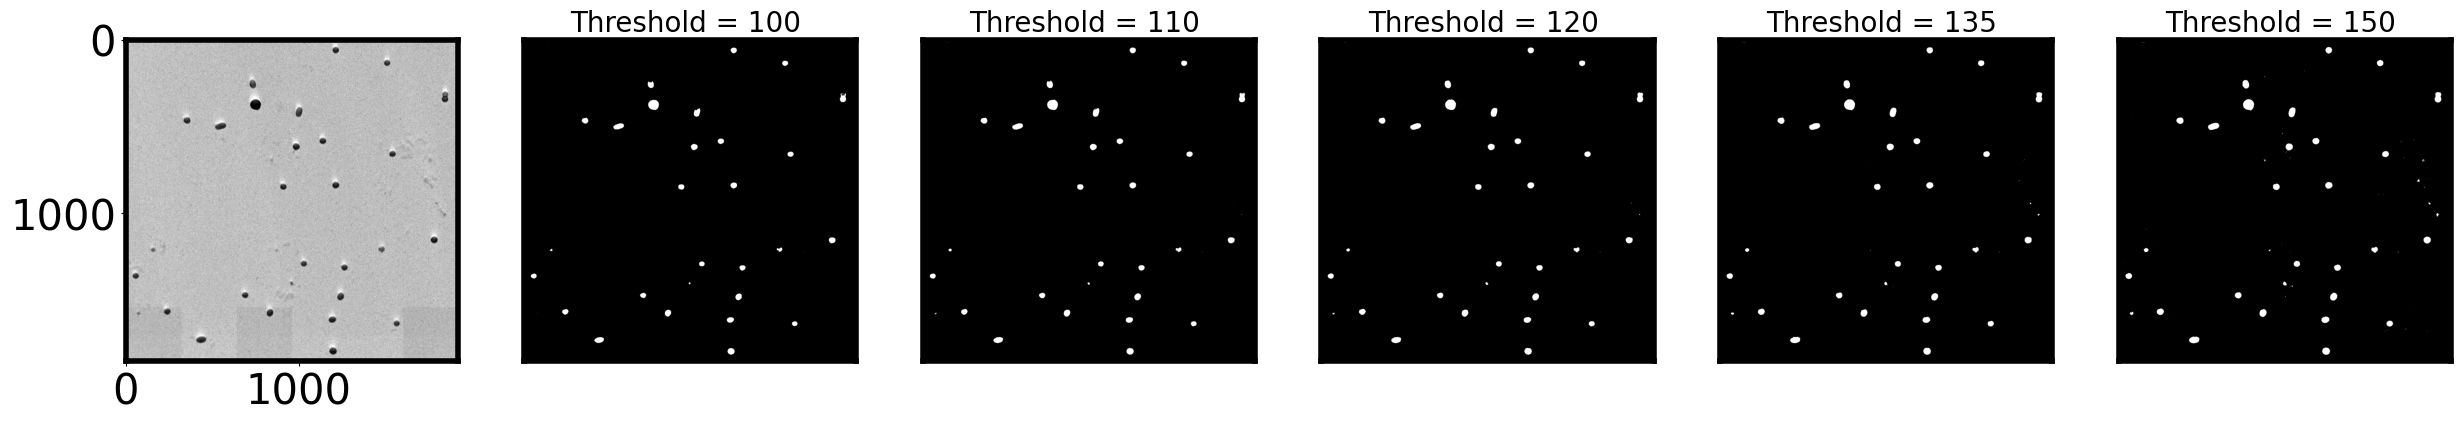

Particle_analysis_files/CC_15_2021_H_0022.dm3
Particle_analysis_files/CC_15_2021_H_0022.dm3 opened as a Micrograph object
Maxmium value :  181
Minimum value :  44


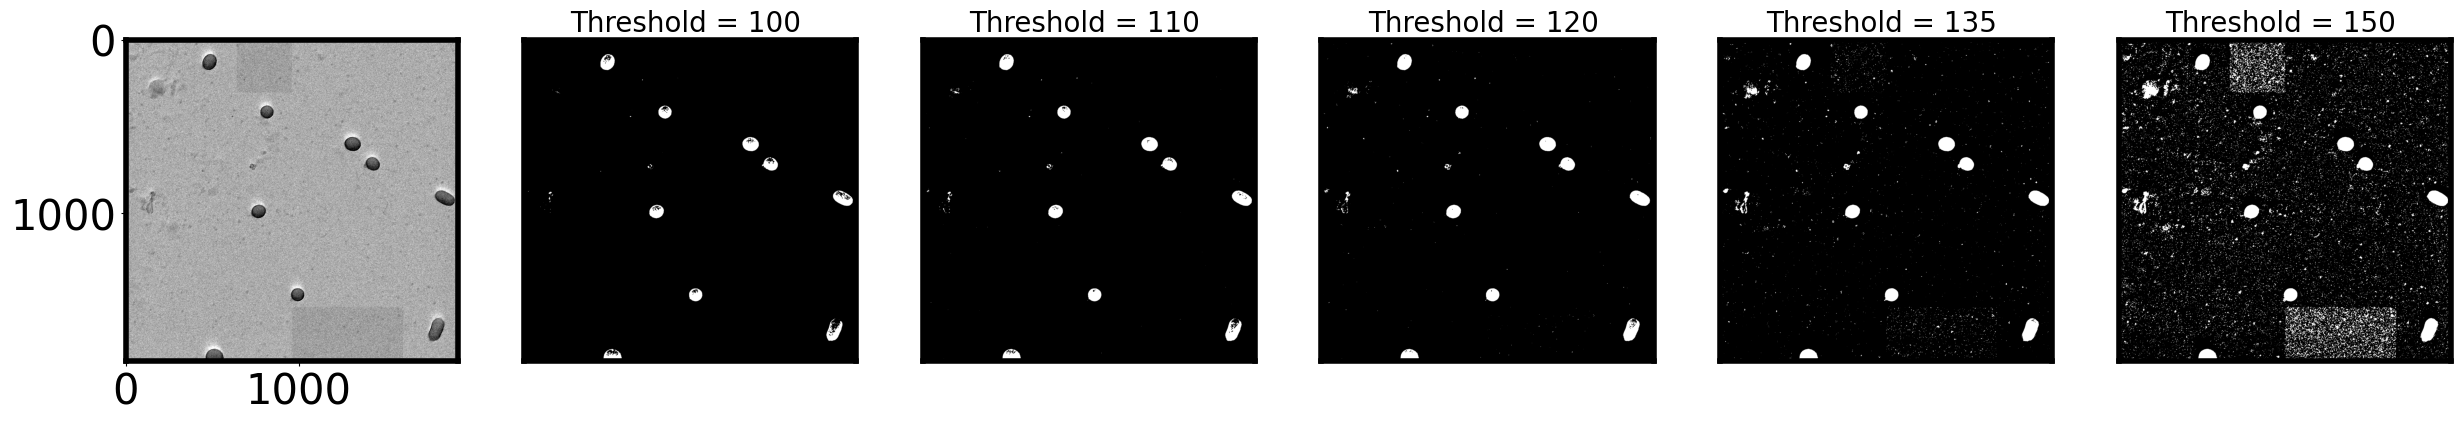

Particle_analysis_files/CC_15_2021_H_0016.dm3
Particle_analysis_files/CC_15_2021_H_0016.dm3 opened as a Micrograph object
Maxmium value :  208
Minimum value :  46


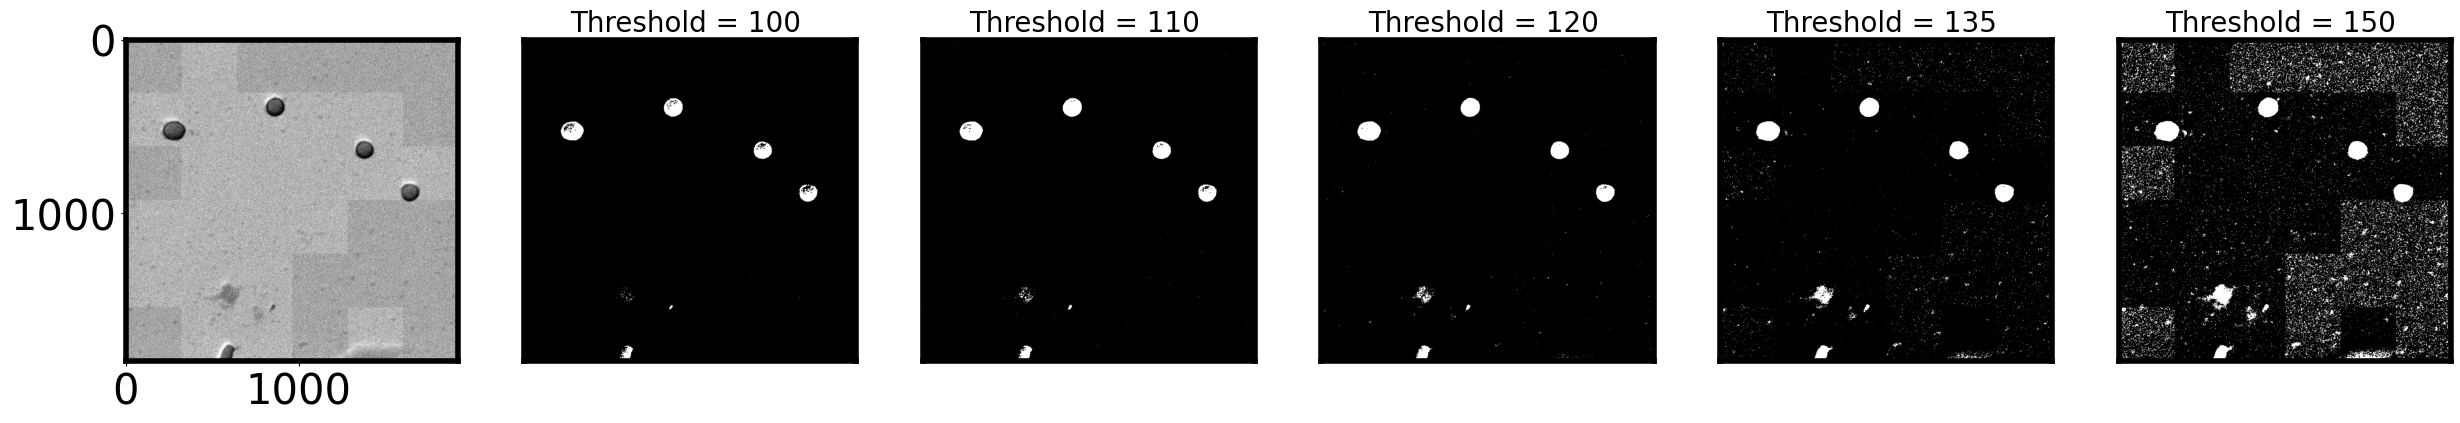

In [30]:
processed_ims = []
for file in files:
    print(file)
    im = Micrograph()
    im.open_dm(file)
    im_processed = preprocess(im)
    processed_ims.append(im_processed)
    plot_thresholds(im_processed)


Now if this is in a jupyter notebook, one can doubleclick on each figure and get a closer look. Here though I have decided for each image what I think the suitable thresholds should be. Now I will save these in a list, these should be the same order as the files in the files list.

One thing to note here is that the particles are filled in in the find_contours function. Therefore the key is getting the edges right. In some of these images, the full particle is not selected but as long as the outline is, we can proceed to the next step. 

In [31]:
thresholds = [120, 130, 120]

Now, remember how the the pixelSize of the image was in µm and I wanted it in nanometers? Lets make sure this is fixed for all images. I'm going to do this with a simple for loop and an if statement: 

In [32]:
for im in processed_ims:
    print(im.filename)
    print('Starting pixelsize = {}{}'.format(str(round(im.pixelSize,3)),im.pixelUnit))
    if im.pixelUnit=='µm':
        im.pixelSize= im.pixelSize*1000
        im.pixelUnit='nm'
    print('New pixelsize = {}{}'.format(str(round(im.pixelSize,3)),im.pixelUnit))
    print('\n')

Particle_analysis_files/CC_15_2021_H_0018.dm3
Starting pixelsize = 0.003µm
New pixelsize = 2.717nm


Particle_analysis_files/CC_15_2021_H_0022.dm3
Starting pixelsize = 1.257nm
New pixelsize = 1.257nm


Particle_analysis_files/CC_15_2021_H_0016.dm3
Starting pixelsize = 0.902nm
New pixelsize = 0.902nm




So now we have a list of pre-processed images and a list of threshold values to use. We can finally get down to it! 

Before we start, we need to create empty lists to store the data. We will then append the data and the masks. 

Now in these images we have different magnifications so the areas in pixels are completely different, making it difficult to use a single `minsize` value, so I am also going to define   different minimum sizes for each image.

In [33]:
minsizes = [700, 2000,2000]

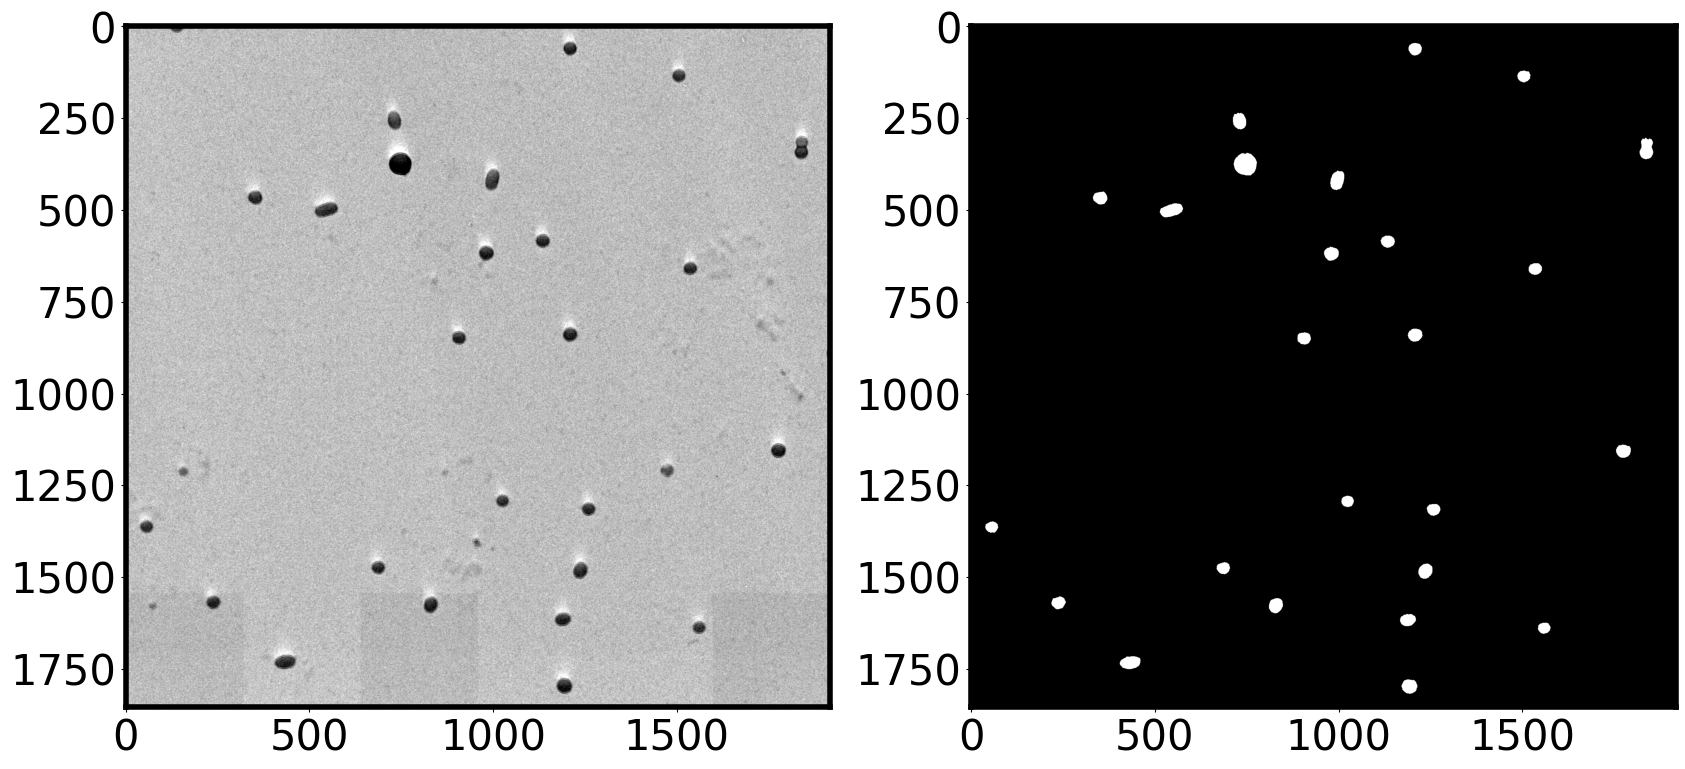

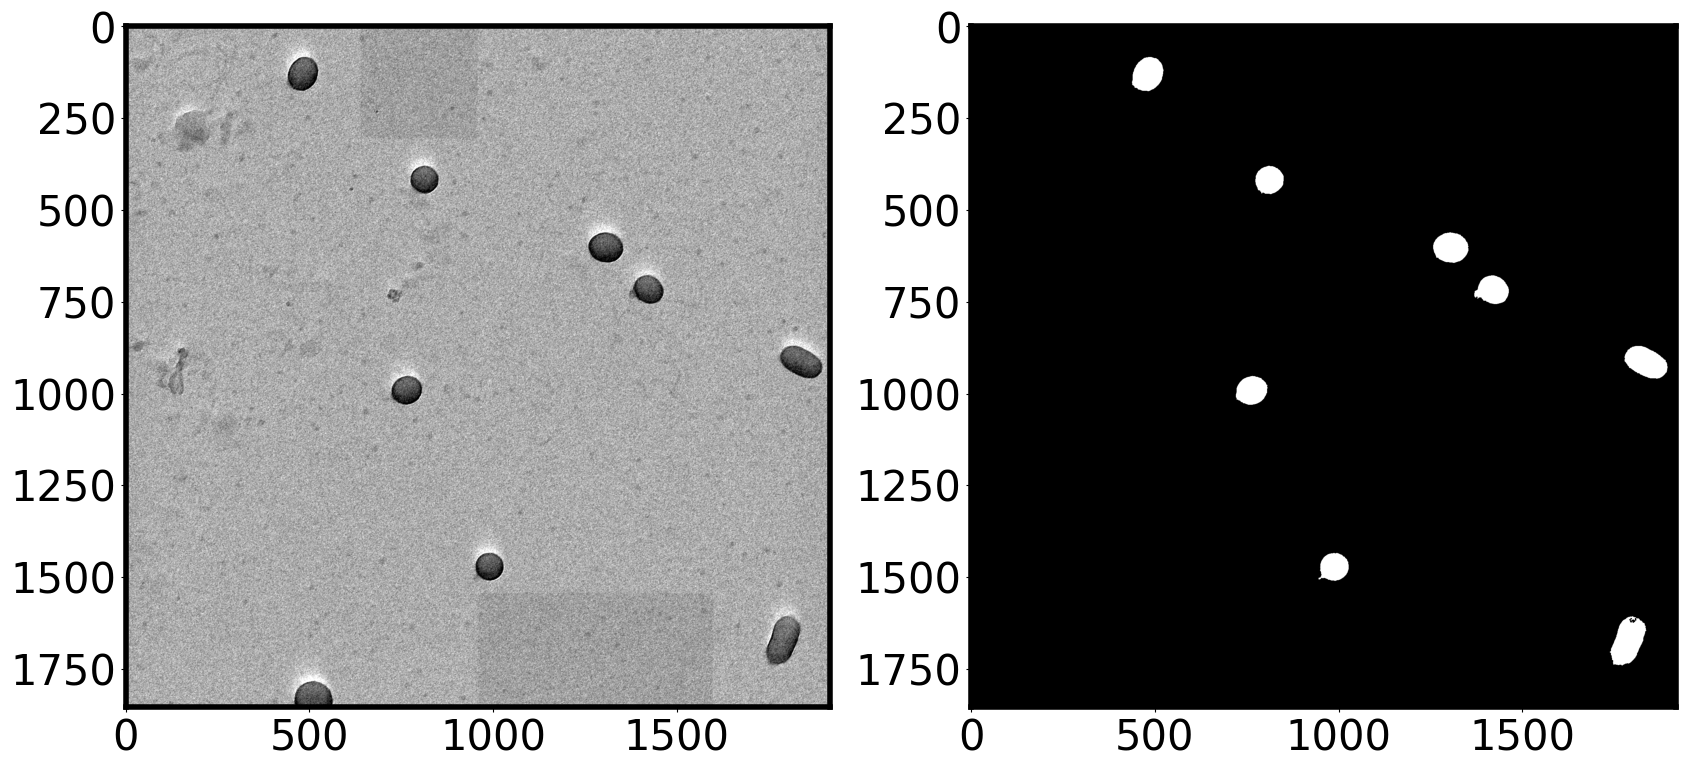

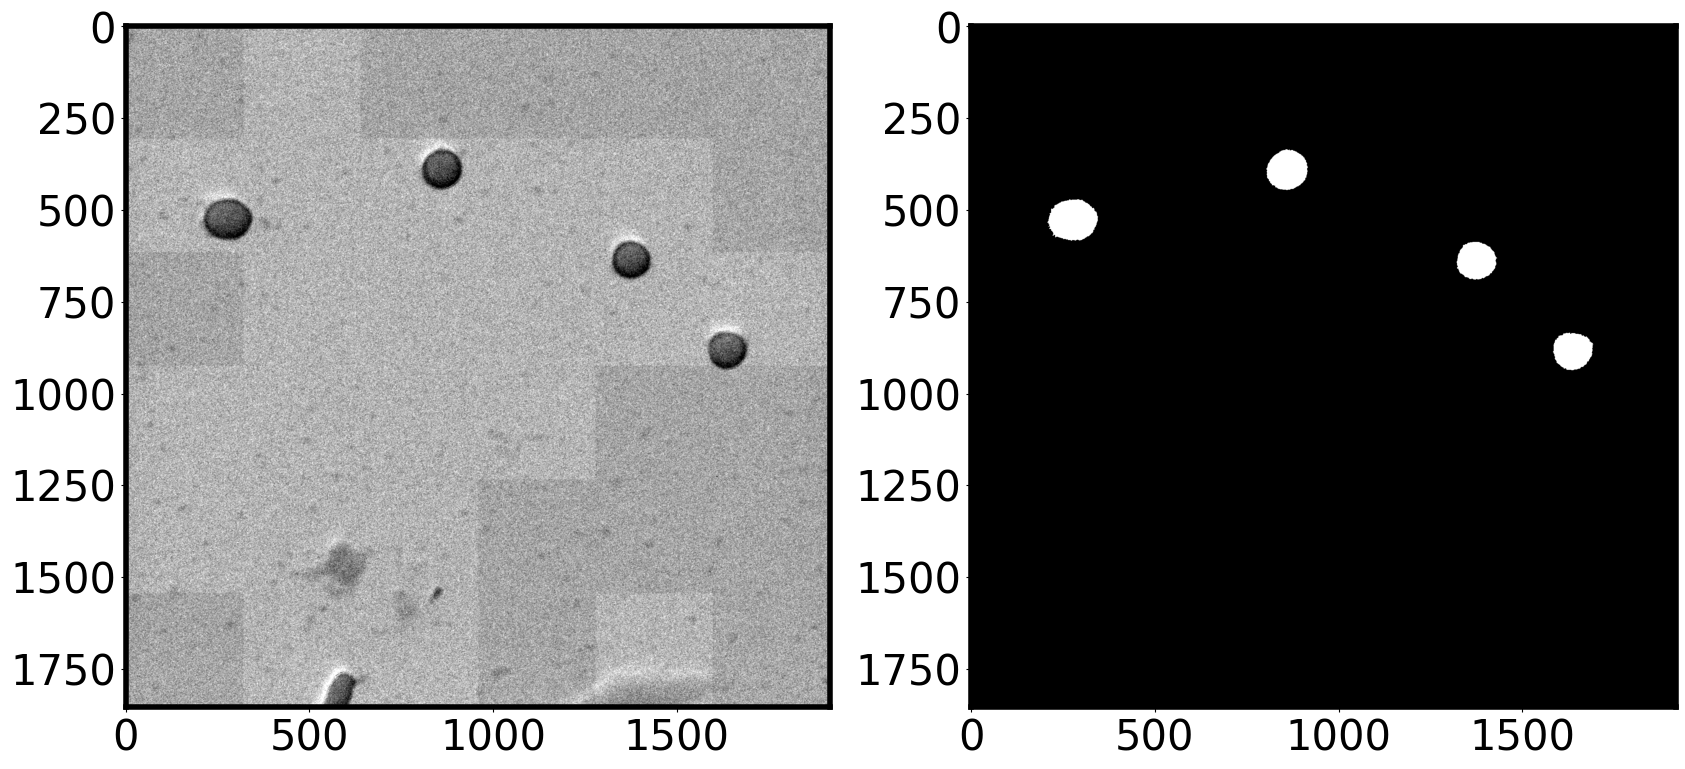

In [34]:
#create lists to store data
masks = []
alldata = []

for i in range(len(processed_ims)):
    #define which image we are working on (just to make code look neater!)
    im = processed_ims[i]
    
    #Threshold
    thresh = Threshold(im.image, thresholds[i])
    
    #Find contours
    contours_im, mask = Find_contours(thresh, minsize=minsizes[i])
    
    #Plot mask to check
    im.show_pair(mask)
    
    
    #Collect data
    data = Collect_particle_data(contours_im, im.pixelSize, multimeasure=True)
    
    #Save the data to the empty lists we created 
    alldata.append(data)
    masks.append(mask)


So, now we have the masks shown above saved if we want them again, and more importantly we have the data in the list `alldata`. Now this is a list of dictionaries, we will make this into one dataset in a second, but first, lets see if the particles have similar sizes across the images:

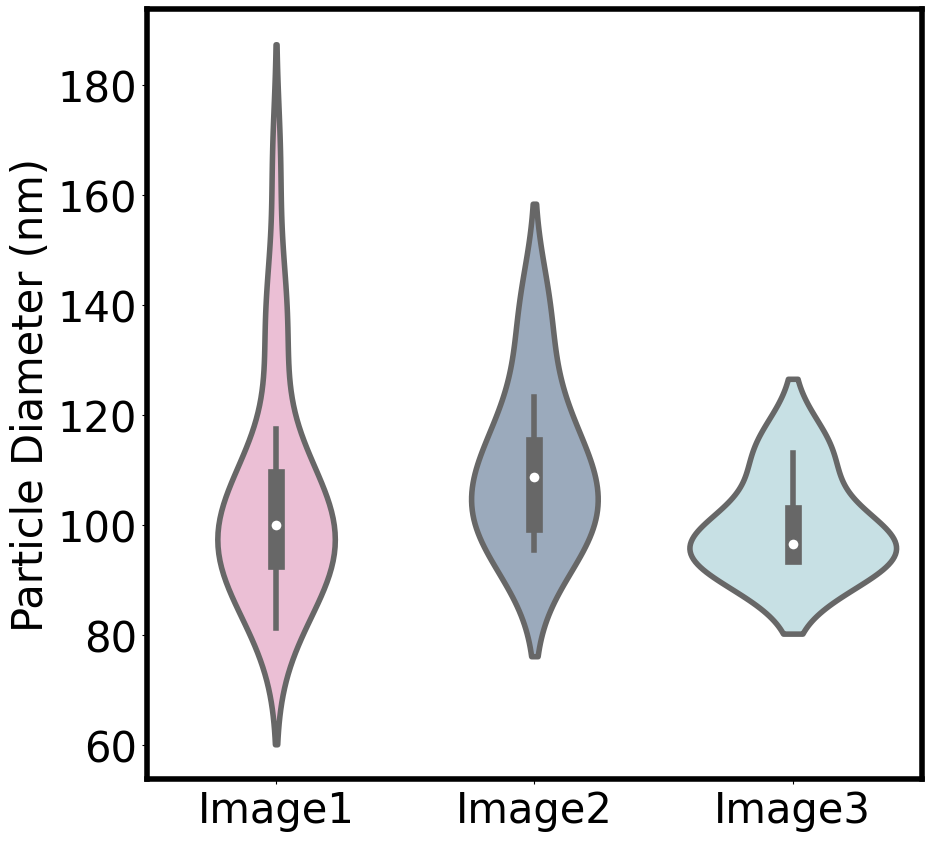

In [35]:

means = [x['Mean diameter'] for x in alldata]

fig,ax = plt.subplots(figsize=(10,10))

seaborn.violinplot(data=means)
ax.set_ylabel('Particle Diameter (nm)')
ax.set_xticklabels(['Image1','Image2','Image3'])
plt.show()

Looks good! there are only a few particles in the second and third image, so not going to get great statistics or identical means, but they are definitely scaling correctly! Now lets join the data together:

### Joining data together
Now we have a list of dictionarys - we can make this into one dictionary like this:

In [36]:
# make an new empty dictionary
alldata_dict = {}

#Create empty options for each key value
for key in alldata[0].keys():
    alldata_dict[key]= [] 

#Append the data from each dataset into the new dictionary
for dset in alldata:
    for key in dset:
        alldata_dict[key].append(dset[key])

This puts it into one dictionary, the only problem is the data in each category is split into lists from each image. This can be fixed using one confusing line of code, or alternatively the function Flatten_list(). You can see this if you look  below.

In [37]:
#Check the condition at the start 
print('There are {} datasets in the dictionary'.format(len(alldata_dict['Width'])))

There are 3 datasets in the dictionary


In [38]:

width_data = [x for i in alldata_dict['Width'] for x in i]
print('There is now a single dataset with {} datapoints'.format(len(width_data)))

#or more conveniently: 

width_data = Flatten_list(alldata_dict['Width'])
print('There is now a single dataset with {} datapoints'.format(len(width_data)))

There is now a single dataset with 37 datapoints
There is now a single dataset with 37 datapoints


To simplify things, there is a function called `Convert_to_single_dict` which does this last couple of steps for you. The parameter `combine_data` defines whether you want too combine the datasets (or flatten the lists) as above, or keep them separate, here I will be keeping them separate.

In [39]:
alldata_dict = Convert_to_single_dict(alldata, combine_data=False)

Now lets make a similar plot as we did for the single image, except this time, lets colour the positions by which image they are from: 

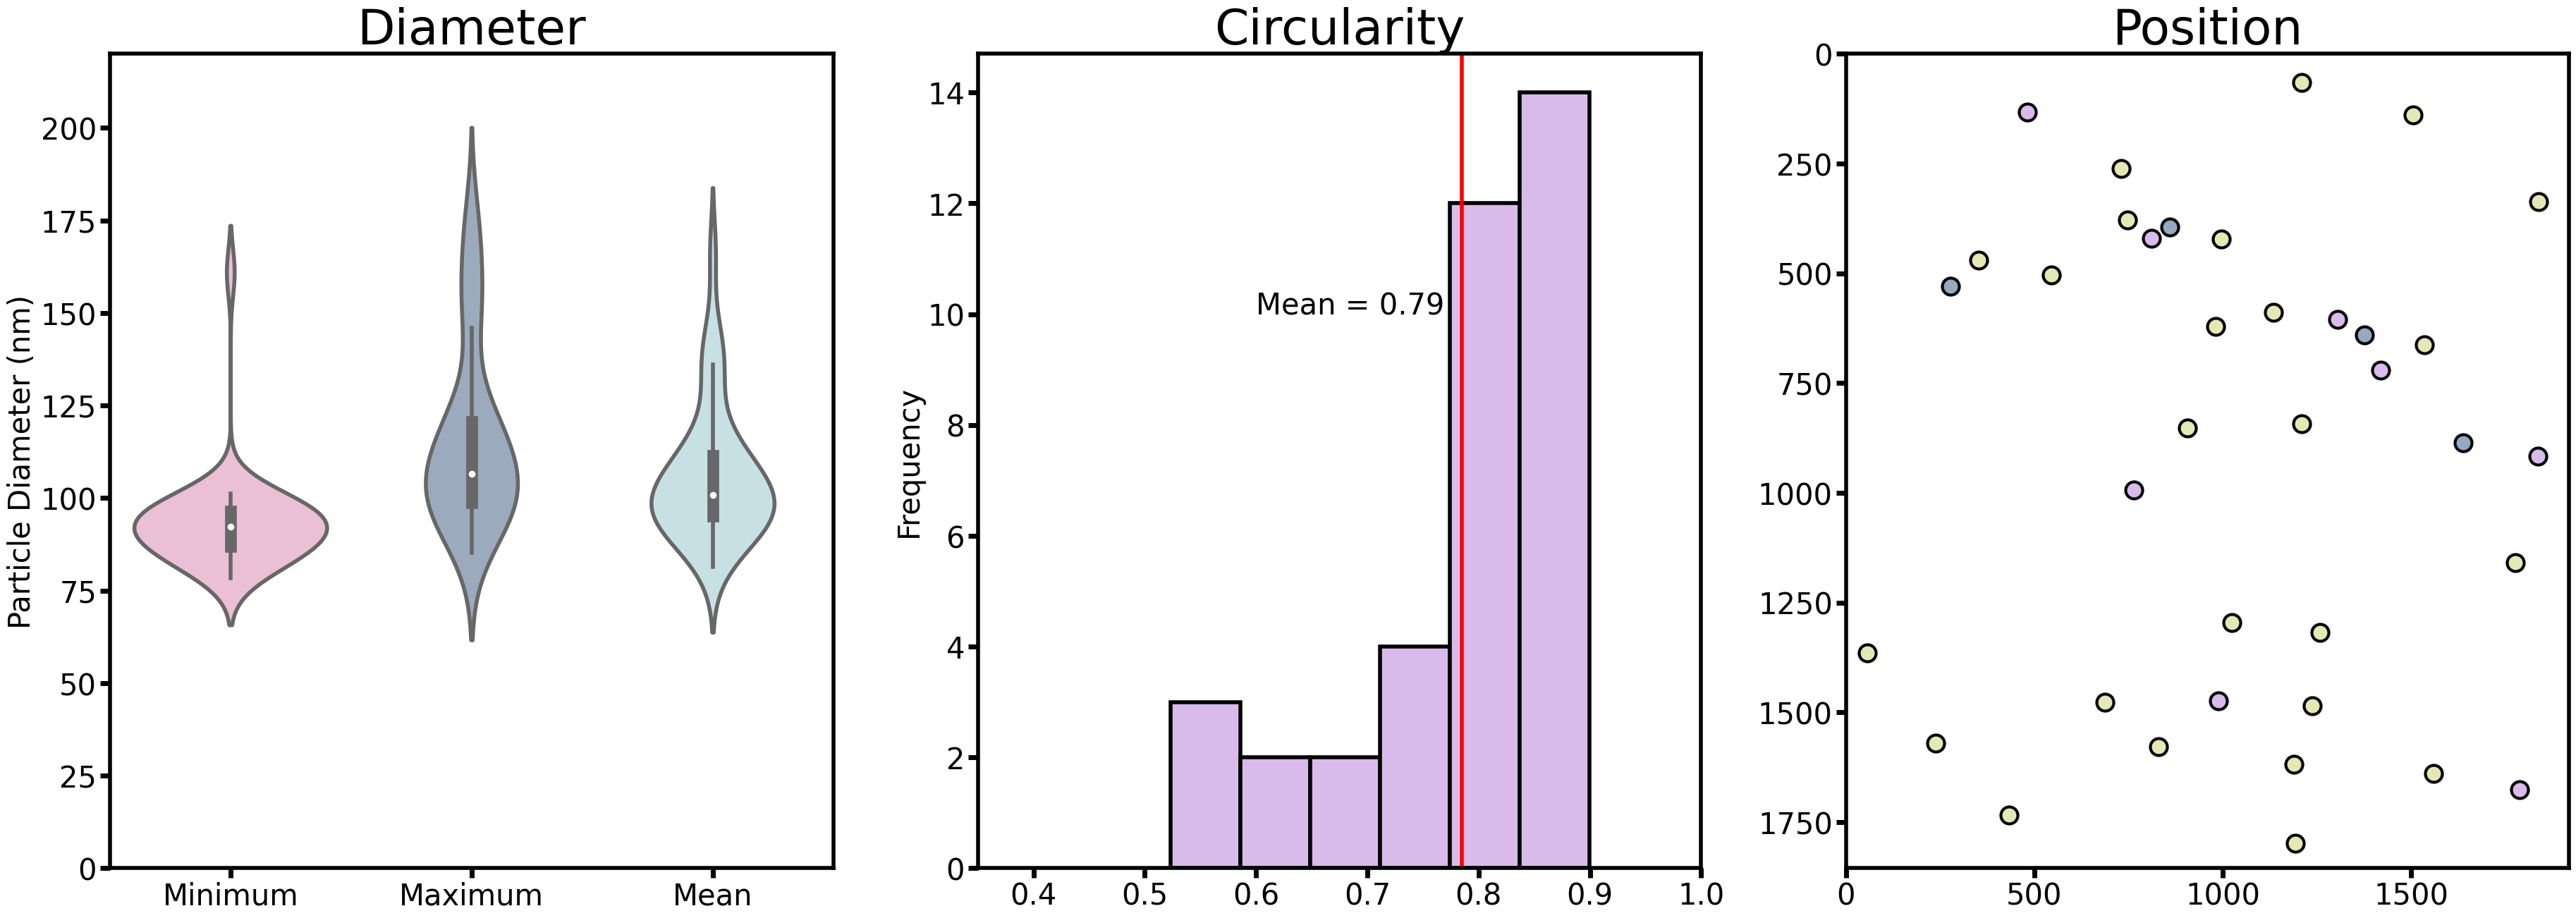

In [40]:
#Get data 
hdata= Flatten_list(alldata_dict['Max diameter'])
wdata = Flatten_list(alldata_dict['Min diameter'])
mdata = Flatten_list(alldata_dict['Mean diameter'])
cdata= Flatten_list(alldata_dict['Circularity'])

#get x and y positions
xpos =alldata_dict['Centroid_x']
ypos =alldata_dict['Centroid_y']

#Create a figure with 3 subplots
fig, ax = plt.subplots(1,3,figsize=(45,15))

#Change global parameters 
matplotlib.rcParams.update({'font.size': 40}, )
matplotlib.rcParams['axes.linewidth'] = 4
matplotlib.rcParams['lines.linewidth'] = 4

#Make Ticks bigger
for a in ax:
    a.xaxis.set_tick_params(width=5, length=10)
    a.yaxis.set_tick_params(width=5, length=10)

#Set the seaborn color palette to be my color palette
colors = ['#F2B8D5', '#95A9C1','#C2E4E9','#D8BBEA','#E5E8B5']
seaborn.set_palette(seaborn.color_palette(colors))

#Plot the diameter violin plot
seaborn.violinplot([wdata, hdata,mdata] ,ax=ax[0], linewidth=4, edgecolor='black')

#Set violin plot labels and limits
ax[0].set_ylim(0,220)
ax[0].set_title('Diameter', fontsize=50)
ax[0].set_ylabel('Particle Diameter (nm)')
ax[0].set_xticklabels(['Minimum', 'Maximum', 'Mean'])

#Plot histogram of Circularity
ax[1].hist(cdata, color='#D8BBEA',edgecolor='black',linewidth=4, bins=6)
ax[1].set_title('Circularity', fontsize=50)
ax[1].set_ylabel('Frequency')
ax[1].set_xticks([x/10 for x in range(4,11)])
ax[1].set_xlim(0.35,1)

#Add a line to show the mean 
ax[1].axvline(np.mean(cdata), color='red')
label='Mean = ' +str(round(np.mean(cdata),2))
ax[1].annotate(label, (0.6,10), fontsize=30)

#Plot the positions of the particles on a scatter plot
ax[2].scatter( xpos[0], ypos[0] , color='#E5E8B5', marker='o',edgecolors='black',s=300, linewidth=3)
ax[2].scatter( xpos[1], ypos[1] , color='#D8BBEA', marker='o',edgecolors='black',s=300, linewidth=3)
ax[2].scatter( xpos[2], ypos[2] , color='#95A9C1', marker='o',edgecolors='black',s=300, linewidth=3)
ax[2].set_title('Position', fontsize=50)
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_xlim(0, 1919)
ax[2].set_ylim(1855,0)

#Show plot (can also use plt.savefig('Name.png') to save the figure)
plt.show()

Well we haven't changed much as there were only a few extra particles in the next images, but the satistics have improved and the data is similar! 

## Saving data

Here I make it into a Pandas dataframe and save it as a .csv file

Pandas is a python module which is excellent for handling data in 'dataframes', theses are analogous to an excel spreadsheet.

Before doing anything, lets go back and ensure that the dictionary (alldata_dict) has all the data in a single list:

In [41]:
alldata_dict = Convert_to_single_dict(alldata, combine_data=True)

Now we have a standard dictionary for our data, we can convert it to a dataframe as follows:

In [42]:
import pandas as pd
df = pd.DataFrame(alldata_dict)

In [43]:
#Lets have a look at the result - this prints the first 5 lines
df.head()

Area  Centroid_x   Centroid_y   Perimeter  Circularity      Width  \
0   5743.435391   56.155099  1365.184876  292.734227     0.827623  81.511207   
1   7020.574623  237.854890  1571.084823  324.406368     0.802943  87.850084   
2   7426.601547  351.651922   469.973492  327.589579     0.838994  91.328990   
3  10925.815396  433.386036  1733.704279  418.104266     0.578564  92.379368   
4  12132.822705  545.268228   503.501673  456.802094     0.524713  87.263909   

       Height     Radius  Major-Minor Ratio  Min diameter  Max diameter  \
0   92.379368  46.999643           1.133333     81.556479     92.419316   
1  105.031116  52.755651           1.195572     84.926525    105.510758   
2  104.135275  53.081211           1.140221     97.397461    102.421967   
3  152.154254  77.531194           1.647059     99.756457    153.554846   
4  171.037261  85.791647           1.960000     85.056814    169.461432   

   Mean diameter  Stddev diameter  Measurements  Image number  
0      86.624071         3.892399            16             0  
1      95.017486         6.795144            18             0  
2     100.052019         1.779500            14             0  
3     133.305639        16.152189            32             0  
4     144.062945        26.443195            38             0

Finally, lets save the data as a .csv (comma-separated values) file, this is easy to open with a text editor, excel, python or many other programs that you may wish to use:

In [44]:
df.to_csv('Particle_data.csv')